## Final summary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 part 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

/opt/miniconda3/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/miniconda3/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/miniconda3/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


22/10/09 09:26:23 WARN Utils: Your hostname, mast30034 resolves to a loopback address: 127.0.1.1; using 45.113.234.45 instead (on interface eth0)
22/10/09 09:26:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 09:26:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 09:26:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/09 09:26:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/09 09:26:25 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/09 09:26:25 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [2]:
%run "../scripts/ETL.py" '../scripts/paths.json'

22/10/09 09:26:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


The following dataset is the full internal + external dataset merged together. 

In [3]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

22/10/09 09:27:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,suburb,postcodes,long,lat,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021,fraud_probability_consumer,fraud_probability_merchant
null,null,null,null,null,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,32234779638,39.304036732369084,02e36af7-8c70-436...,2021-11-30,18983,36103,REVESBY,2212,151.014547,-33.947286,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710,0.01,0.01
Lorem Ipsum Sodal...,43186523025,florists supplies...,4.47,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,43186523025,56.35375319523918,a1d3526c-f212-41f...,2022-06-06,18983,36103,REVESBY,2212,151.014547,-33.947286,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710,0.01,0.01
Pede Blandit LLP,28517327395,"books, periodical...",0.47,e,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,28517327395,276.3597685809581,b90e183b-25d4-4a6...,2022-06-14,18983,36103,REVESBY,2212,151.014547,-33.947286,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710,0.01,0.01
Nullam Suscipit LLC,86388904574,"computers, comput...",4.96,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,86388904574,121.9799348513232,4c55adbf-7114-4bd...,2022-05-24,18983,36103,REVESBY,2212,151.014547,-33.947286,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710,0.01,0.01
Phasellus At Limited,76767266140,"furniture, home f...",4.65,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,76767266140,59.46778996058449,4e66a3c6-9691-44a...,2022-03-05,18983,36103,REVESBY,2212,151.014547,-33.947286,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710,0.01,0.01


### Outlier Analysis

- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [4]:

%run "../scripts/outlier.py" '../scripts/paths.json'

22/10/09 09:29:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 92.12% for 33 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 89.41% for 34 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 86.86% for 35 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 84.44% for 36 writers
22/10/09 09:30:12 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:30:26 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:30:28 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers


22/10/09 09:30:29 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:30:29 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers


22/10/09 09:30:29 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:30:29 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:30:29 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:30:30 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:30:31 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:30:31 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers


22/10/09 09:30:31 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:30:31 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers


22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:30:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers


22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 54.29% for 56 writers


22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 55.27% for 55 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 56.30% for 54 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 57.36% for 53 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 58.46% for 52 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 59.61% for 51 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 60.80% for 50 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 74.15% for 41 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 76.00% for 40 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 77.95% for 39 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 80.00% for 38 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 82.16% for 37 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 84.44% for 36 writers
22/10/09 09:30:33 WARN MemoryManager: Total allocation exceeds 9

In [5]:
df.head()

,Outlier removal,Count after outlier removal
0,Original count,10540321
1,Valid Merchant ABN,10109371
2,Transactions with non $0,10109371
3,Valid customer ID,10109371
4,Non null values for gender,10109371


As seen above, null values were only present in the merchant abn column which
were removed to prepare the final dataset

### Tags to categories


In [6]:
%run "../scripts/NLP.py" '../scripts/paths.json'

22/10/09 09:30:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
THE TOP 15 WORDS FOR TOPIC #FURNITURE
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC #TOYS AND DIY
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC #BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC #BOOKS, STATIONARY AND MUSIC
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS

In [7]:
merchants_df.head(5)

,name,tags,merchant_abn,cleaned_tags,store_type,category
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...",10142254217,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...",10165489824,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...",10187291046,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...",10192359162,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"


### Visualize internal data

22/10/09 09:30:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 92.12% for 33 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 89.41% for 34 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 86.86% for 35 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 84.44% for 36 writers
22/10/09 09:31:32 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:35 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers


22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:31:36 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers


22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 54.29% for 56 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 55.27% for 55 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 56.30% for 54 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 57.36% for 53 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 58.46% for 52 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 59.61% for 51 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 92.12% for 33 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
22/10/09 09:31:37 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers


22/10/09 09:31:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 92.12% for 33 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 89.41% for 34 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 86.86% for 35 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap 

22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 66.09% for 46 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 64.68% for 47 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 63.33% for 48 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 62.04% for 49 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 60.80% for 50 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 59.61% for 51 writers
22/10/09 09:31:40 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:48 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:31:49 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers


22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 54.29% for 56 writers
22/10/09 09:31:50 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:31:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:35:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


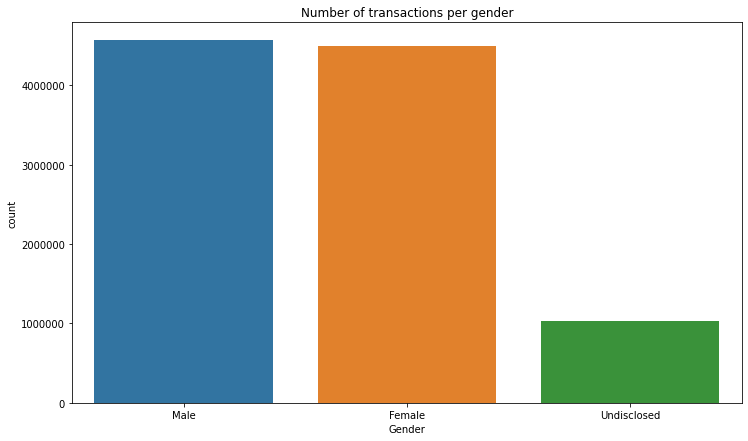

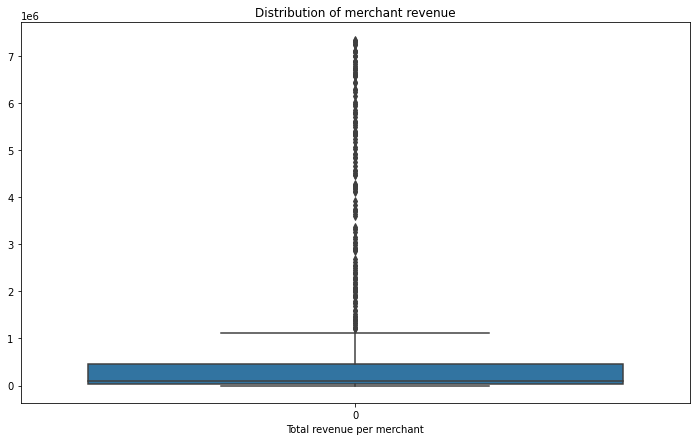

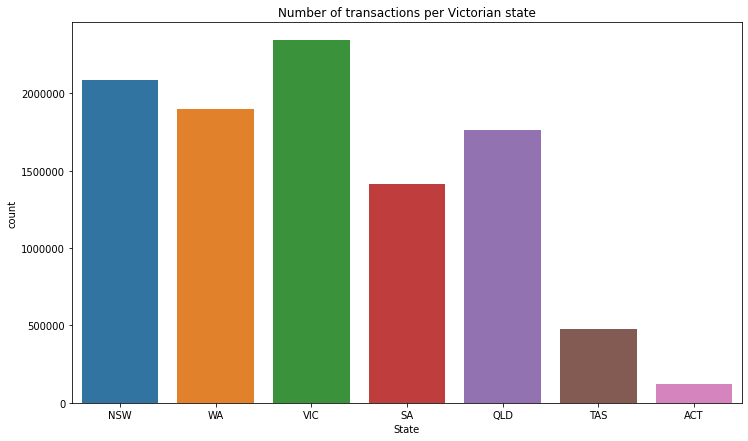

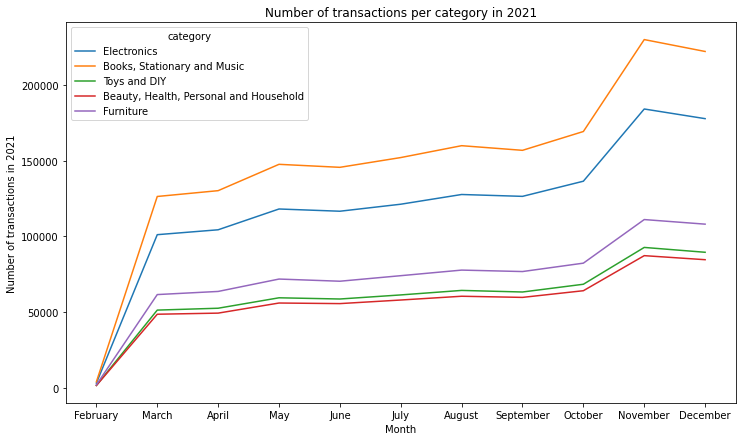

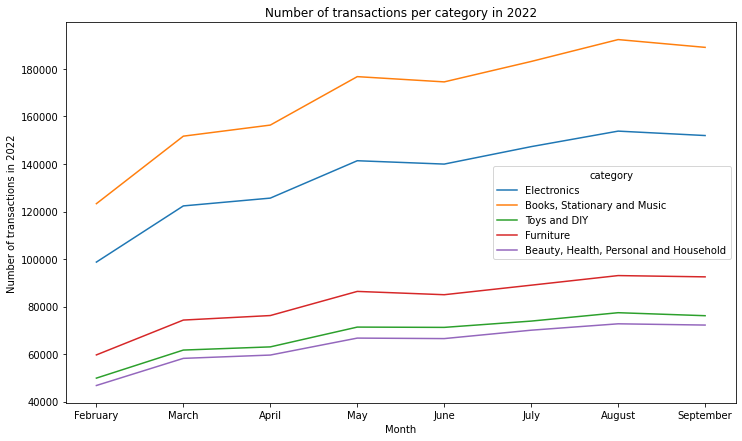

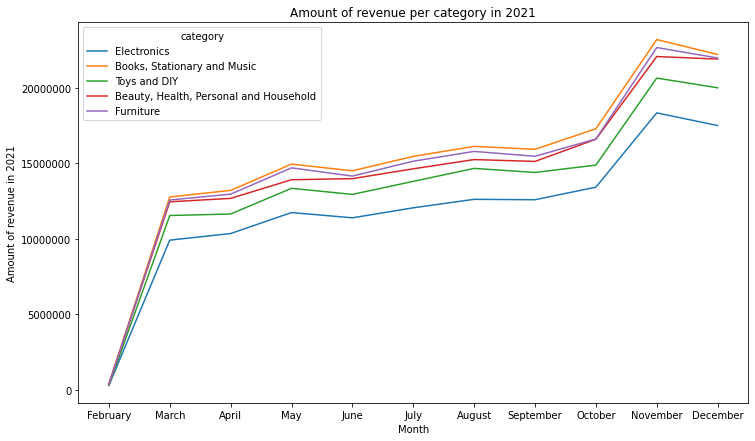

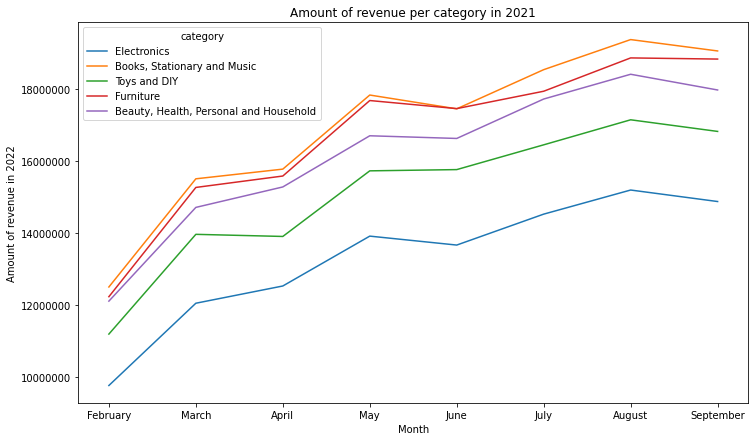

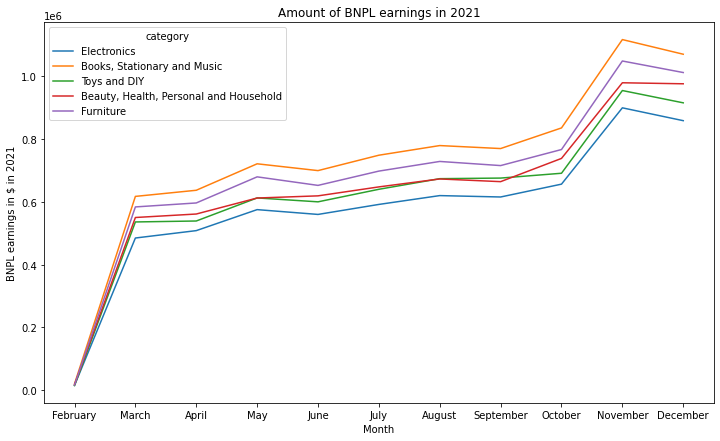

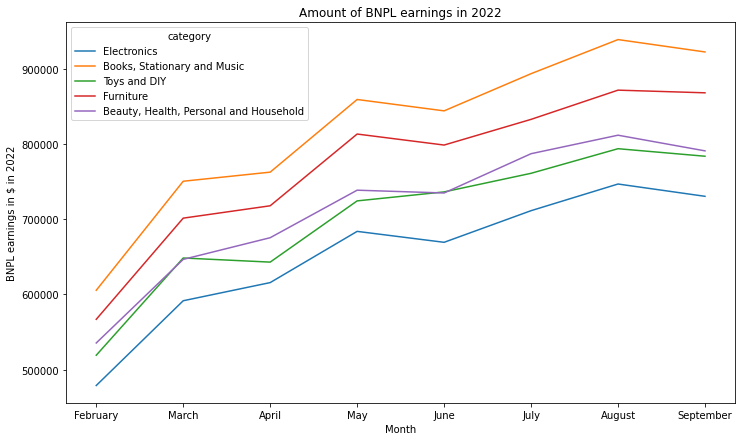

In [8]:
%run "../scripts/visualizations-1.py" '../scripts/paths.json'

### Visualizaing the fraud data

22/10/09 09:37:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


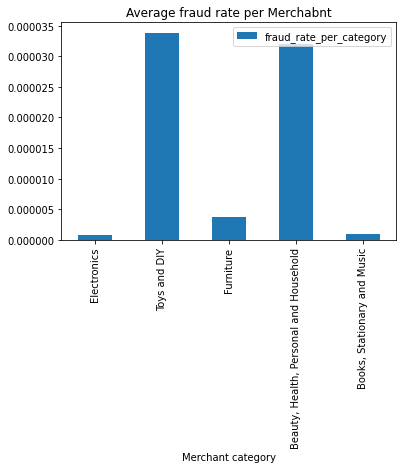

In [9]:
%run "../scripts/Fraud_viz.py" '../scripts/paths.json'

### External datasets - Outliers

22/10/09 09:37:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Summary statistics for the Census data - 


           SA2_code   total_males  total_females  total_persons
count  2.472000e+03   2472.000000    2472.000000    2472.000000
mean   3.177555e+08   5074.887136    5209.415049   10284.254450
std    1.977886e+08   3019.275754    3161.883118    6171.395057
min    1.010210e+08      0.000000       0.000000       0.000000
25%    1.270315e+08   2669.750000    2678.000000    5384.750000
50%    3.030411e+08   4774.000000    4875.000000    9656.000000
75%    4.060111e+08   7169.000000    7511.500000   14675.000000
max    9.999995e+08  14327.000000   13783.000000   28116.000000


Summary statistics for the Income data - 


    SA2_code           SA2_name  income_2018-2019
0  101021007          Braidwood         120763285
1  101021008            Karabar         338308979
2  101021009         Queanbeyan         441160946
3  101021010  

[]


Summary statistics for the Population data - 


    SA2_code                         SA2_name  state_code       state_name  \
0  101021007                        Braidwood           1  New South Wales   
1  101021008                          Karabar           1  New South Wales   
2  101021009                       Queanbeyan           1  New South Wales   
3  101021010                Queanbeyan - East           1  New South Wales   
4  101021012  Queanbeyan West - Jerrabomberra           1  New South Wales   

   population_2020  population_2021  
0             4273             4330  
1             8519             8546  
2            11437            11370  
3             5077             5093  
4            12796            12743  


Summary statistics for the population in 2020 per SA2 code data - 


count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Nam

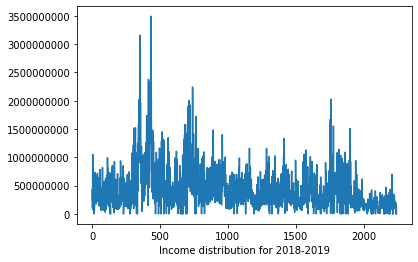

In [10]:
%run "../scripts/outlier_external.py" '../scripts/paths.json'

### Checking the impact of Covid-19 on the number of transactions

22/10/09 09:37:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


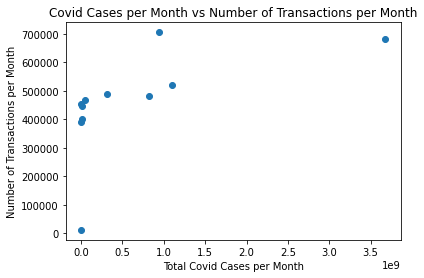

<Figure size 432x288 with 0 Axes>

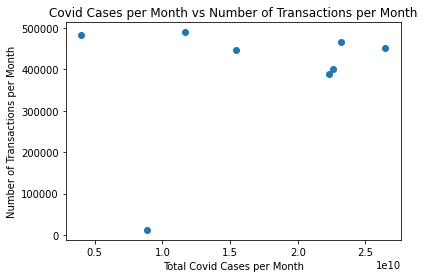

In [11]:
%run "../scripts/covid_viz.py" '../scripts/paths.json'

### Ranking models 

In [12]:
%run "../scripts/BNPL_earning_model.py" '../scripts/paths.json'

22/10/09 09:37:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:37:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 09:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:38:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:38:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 09:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB


22/10/09 09:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1035.2 KiB


22/10/09 09:39:09 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB


22/10/09 09:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1151.4 KiB


22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_58 in memory! (computed 14.0 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_25 in memory! (computed 14.0 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_43 in memory! (computed 14.0 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_18 in memory! (computed 21.2 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_26 in memory! (computed 21.2 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_41 in memory! (computed 21.2 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_4 in memory! (computed 21.2 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_1 in memory! (computed 14.0 MiB so far)
22/10/09 09:39:15 WARN MemoryStore: Not enough space to cache rdd_2033_12 in memory! (computed 21.2 MiB so

22/10/09 09:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB


22/10/09 09:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1334.2 KiB


22/10/09 09:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1573.2 KiB


22/10/09 09:39:26 WARN DAGScheduler: Broadcasting large task binary with size 2024.0 KiB


22/10/09 09:39:59 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB


22/10/09 09:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB


22/10/09 09:40:28 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB


22/10/09 09:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB


In [13]:
# Run all the models to get the features for the ranking model
%run "../scripts/Revenue_model.py" '../scripts/paths.json'

22/10/09 09:41:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1036.5 KiB


22/10/09 09:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1036.6 KiB


22/10/09 09:43:12 WARN DAGScheduler: Broadcasting large task binary with size 1040.6 KiB


22/10/09 09:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1152.9 KiB


22/10/09 09:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1214.6 KiB


22/10/09 09:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1335.8 KiB


22/10/09 09:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1569.5 KiB


22/10/09 09:43:25 WARN DAGScheduler: Broadcasting large task binary with size 2017.2 KiB


22/10/09 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1041.8 KiB


22/10/09 09:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1042.9 KiB


22/10/09 09:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1041.8 KiB


22/10/09 09:44:30 WARN DAGScheduler: Broadcasting large task binary with size 1042.9 KiB


In [14]:
%run "../scripts/Customers_model.py" '../scripts/paths.json'

22/10/09 09:45:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1050.2 KiB


22/10/09 09:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1050.2 KiB


22/10/09 09:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1054.2 KiB


22/10/09 09:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB


22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_6 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_10 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_12 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_2 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_37 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_34 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_16 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN MemoryStore: Not enough space to cache rdd_3632_38 in memory! (computed 36.2 MiB so far)
22/10/09 09:47:21 WARN BlockManager: Persisting block rdd_3632_16 to disk instead.
22/10/09 09:47:21 WARN 

22/10/09 09:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1227.9 KiB


22/10/09 09:47:24 WARN DAGScheduler: Broadcasting large task binary with size 1348.8 KiB


22/10/09 09:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1587.9 KiB


22/10/09 09:47:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/10/09 09:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1055.4 KiB


22/10/09 09:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1056.5 KiB


22/10/09 09:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1055.4 KiB


22/10/09 09:48:40 WARN DAGScheduler: Broadcasting large task binary with size 1056.5 KiB


In [15]:
%run "../scripts/Transactions_model.py" '../scripts/paths.json'

22/10/09 09:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1034.9 KiB


22/10/09 09:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB


22/10/09 09:51:25 WARN DAGScheduler: Broadcasting large task binary with size 1039.0 KiB


22/10/09 09:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1151.3 KiB


22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_23 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_26 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_25 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_19 in memory! (computed 21.2 MiB so far)
22/10/09 09:51:28 WARN BlockManager: Persisting block rdd_4445_19 to disk instead.
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_46 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN BlockManager: Persisting block rdd_4445_46 to disk instead.
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_21 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN MemoryStore: Not enough space to cache rdd_4445_40 in memory! (computed 36.2 MiB so far)
22/10/09 09:51:28 WARN MemoryStore: Not enough spa

22/10/09 09:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1212.7 KiB


22/10/09 09:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB


22/10/09 09:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1572.7 KiB


22/10/09 09:51:36 WARN DAGScheduler: Broadcasting large task binary with size 2039.5 KiB


22/10/09 09:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1040.1 KiB


22/10/09 09:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB


22/10/09 09:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1040.1 KiB


22/10/09 09:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB


In [16]:
%run "../scripts/fraud_feature.py" '../scripts/paths.json'

22/10/09 09:53:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 98.06% for 31 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 95.00% for 32 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 92.12% for 33 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 89.41% for 34 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 86.86% for 35 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 84.44% for 36 writers
22/10/09 09:53:51 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:53:58 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:53:59 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers


22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers


22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.03% for 62 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 48.25% for 63 writers
22/10/09 09:54:00 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 47.50% for 64 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 49.84% for 61 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 50.67% for 60 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 51.53% for 59 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 52.41% for 58 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 53.33% for 57 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 54.29% for 56 writers
22/10/09 09:54:01 WARN MemoryManager: Total allocation exceeds 9

22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 67.56% for 45 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 69.09% for 44 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 70.70% for 43 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 72.38% for 42 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 74.15% for 41 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 95.00% (4,080,218,880 bytes) of heap memory
Scaling row group sizes to 76.00% for 40 writers
22/10/09 09:54:02 WARN MemoryManager: Total allocation exceeds 9

### Evaluating the models

#### Extracting the top 5 important features for each model

In [17]:
%run "../scripts/model_evaluation.py" '../scripts/paths.json'

In [18]:
metrics_df

,Model name,Mean Absolute Error,RMSE
0,Predicted BNPL earnings,10.034929,16.732047
1,Predicted no. of Customers,2.167713,3.111078
2,Predicted Merchant Revenue,206.393219,337.039146
3,Predicted no. of Transactions,2.744784,4.047379


In [19]:
feature_df

,Model name,First Feature,Second Feature,Third Feature
0,Predicted BNPL earnings,BNPL_earnings,no_of_transactions,take_rate
1,Predicted no. of Customers,no_of_customers,total_earnings,income_per_person
2,Predicted Merchant Revenue,total_earnings,no_of_transactions,"category_vec_Beauty, Health, Personal and Hous..."
3,Predicted no. of Transactions,no_of_transactions,total_earnings,merchant_name_vec_Erat Vitae LLP


### Making the ranking model

In [20]:
# take list of values as weights for fraud, transactions, revenue, customer, BNPL earnings
%run '../scripts/ranking_model.py' '../scripts/paths.json' 2,3,5,4,1

Ranking for  Furniture category: 
Number of merchants in this category:  261
Rank  1 :  Erat Vitae LLP
Rank  2 :  Lorem Ipsum Sodales Industries
Rank  3 :  Interdum Feugiat Sed Inc.
Rank  4 :  Eget Laoreet Posuere PC
Rank  5 :  Phasellus At Limited
Rank  6 :  Libero Et Limited
Rank  7 :  Purus Gravida Sagittis Ltd
Rank  8 :  Auctor Company
Rank  9 :  Ornare Limited
Rank  10 :  Phasellus Dapibus Incorporated


Ranking for  Electronics category: 
Number of merchants in this category:  317
Rank  1 :  Lacus Consulting
Rank  2 :  Placerat Eget Venenatis Limited
Rank  3 :  Ipsum Dolor Sit Corporation
Rank  4 :  Mauris Non Institute
Rank  5 :  Phasellus At Company
Rank  6 :  Dictum Phasellus In Institute
Rank  7 :  Ultricies Dignissim LLP
Rank  8 :  Orci In Consequat Corporation
Rank  9 :  Ornare Fusce Inc.
Rank  10 :  Faucibus Leo Ltd


Ranking for  Toys and DIY category: 
Number of merchants in this category:  196
Rank  1 :  Leo In Consulting
Rank  2 :  Vehicula Pellentesque Corporation
Ran

### Insights 

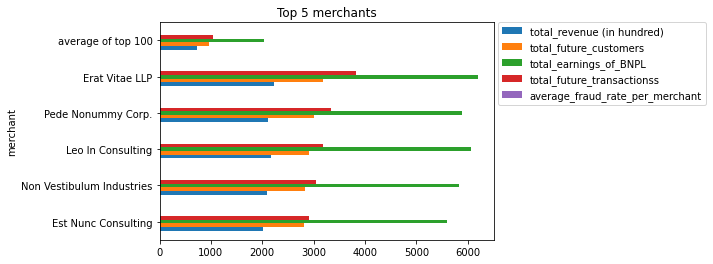

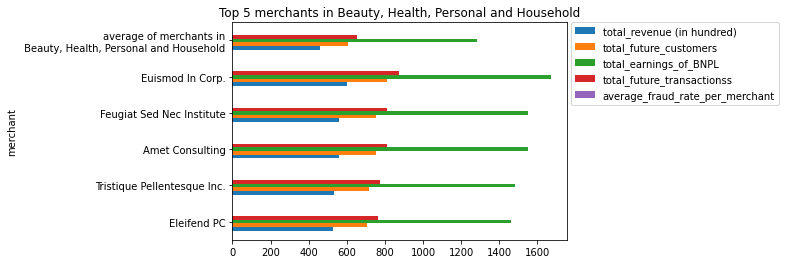

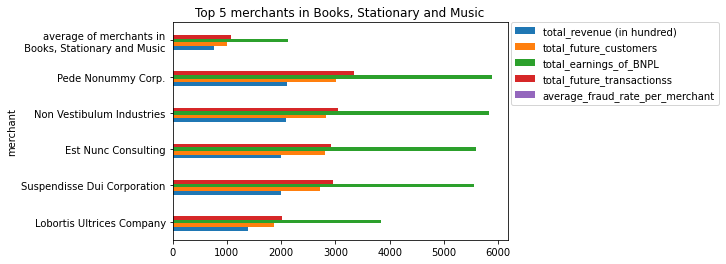

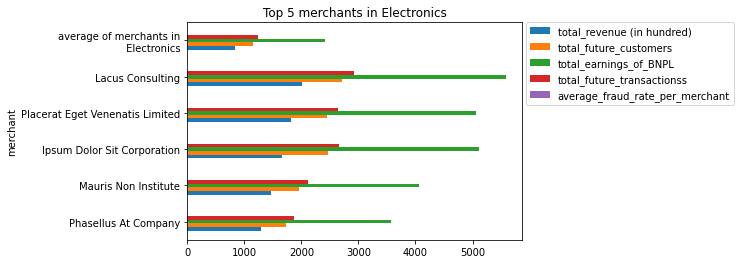

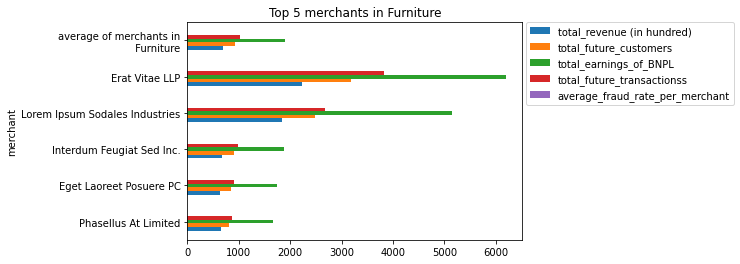

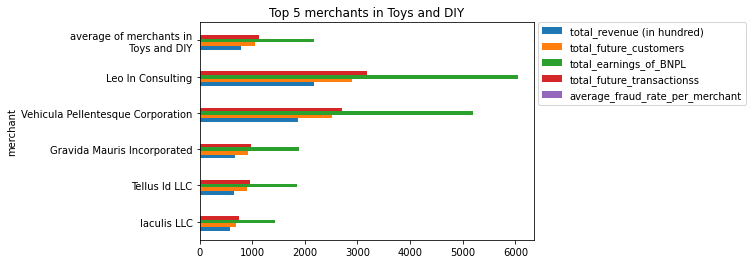

In [21]:
%run "../scripts/visualizations-2.py" '../scripts/paths.json'

22/10/09 09:54:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


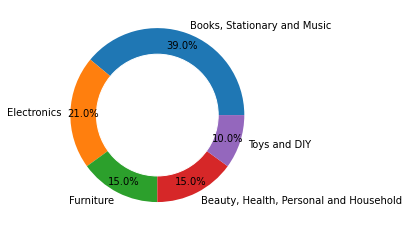

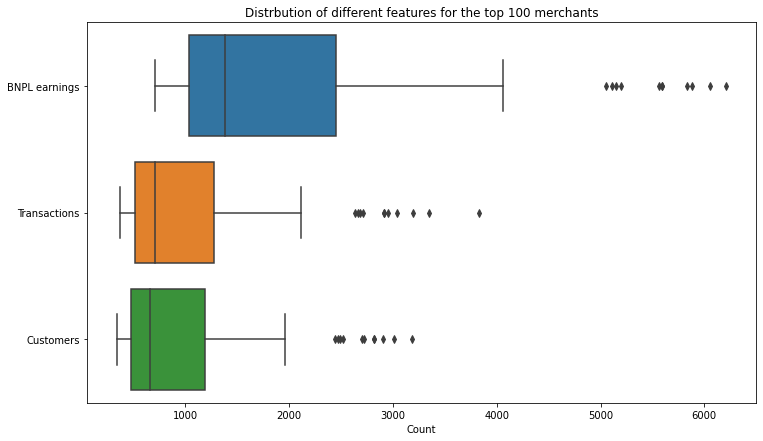

In [22]:
%run "../scripts/insights.py" '../scripts/paths.json'